# Hierarhical Modeling with MCMC

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_context('poster')

%matplotlib inline

import pymc3 as pm

import scipy

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Exploration

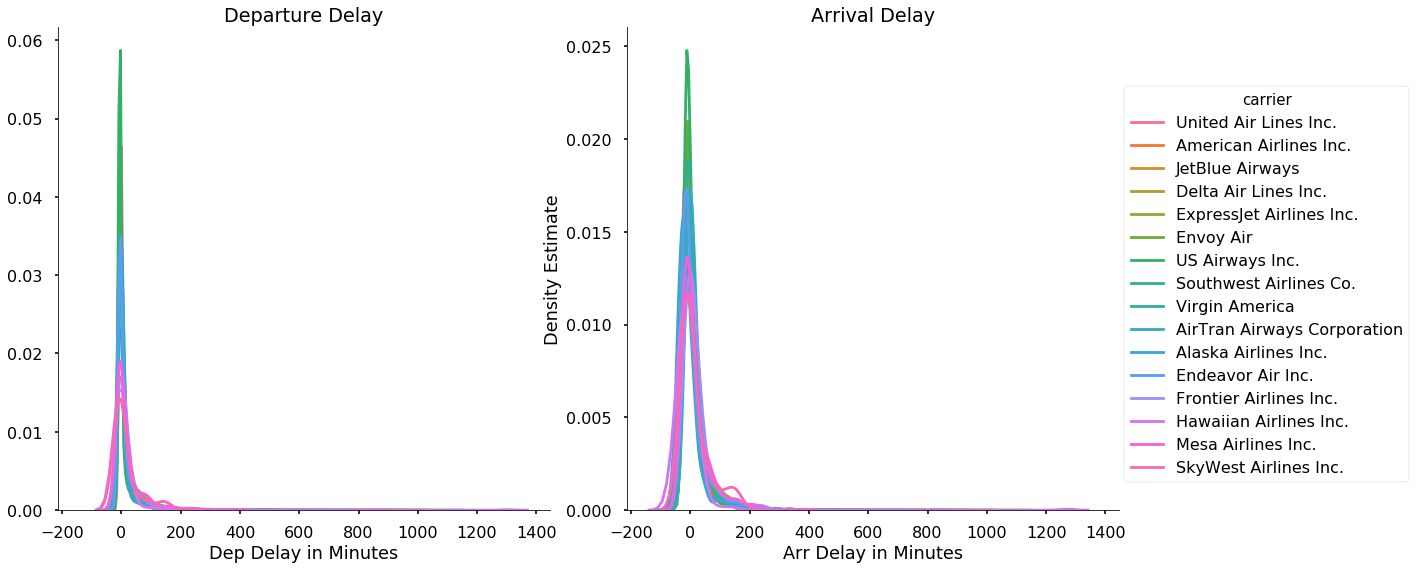

In [2]:
flights = pd.read_csv('data/flights.csv', index_col=0)
flights.dropna(subset=['dep_delay', 'arr_delay'], inplace=True)

carriers = pd.read_csv('data/airlines.csv')
flights = flights.merge(carriers, how = 'left', on = 'carrier' )
flights['carrier'] = flights['name']
flights.drop(columns='name', inplace=True)


flights_subset = flights[['carrier', 'dep_delay', 'arr_delay']]
flights_melted = flights_subset.melt(id_vars='carrier', value_name='value', var_name='type')

figsize(16, 8)
grid = sns.FacetGrid(flights_melted, col = 'type', hue = 'carrier', size=8, sharey=False)
grid.map(sns.kdeplot, 'value')
grid.add_legend();
ax1 = grid.axes[0][0]
ax1.set_xlabel('Dep Delay in Minutes')
ax1.set_title('Departure Delay')

ax2 = grid.axes[0][1]
ax2.set_xlabel('Arr Delay in Minutes')
ax2.set_title('Arrival Delay');
plt.ylabel('Density Estimate');

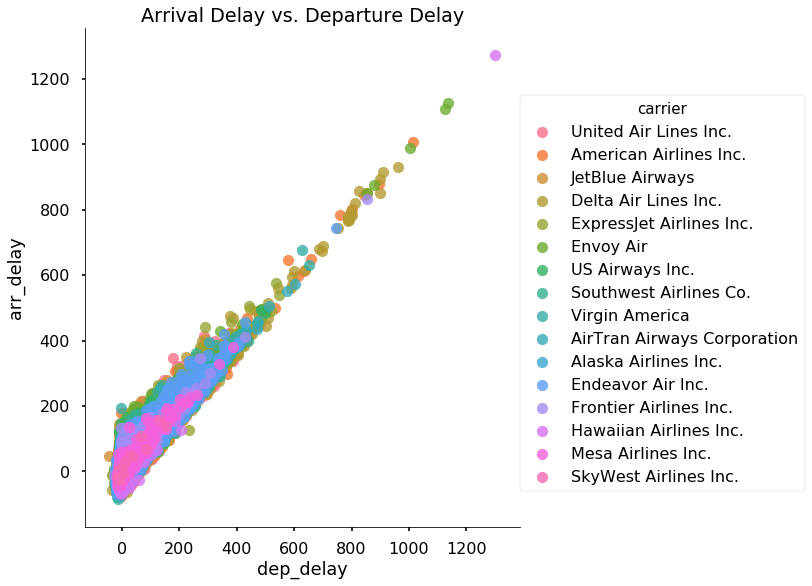

In [3]:
sns.lmplot('dep_delay', 'arr_delay', flights, 
           fit_reg = False, hue = 'carrier', size = 8);
plt.title('Arrival Delay vs. Departure Delay');

In [4]:
flights = flights.sample(frac=1, random_state=50)[:10000]

In [5]:
carriers = flights['carrier'].unique()
carrier_lookup = dict(zip(carriers, range(len(carriers))))
carrier_codes = flights['carrier_code'] = flights['carrier'].replace(carrier_lookup).values

# Hierarchical Model for Flight Delay

In [6]:
dep = np.array(flights['dep_delay'].values)
arr = np.array(flights['arr_delay'].values)

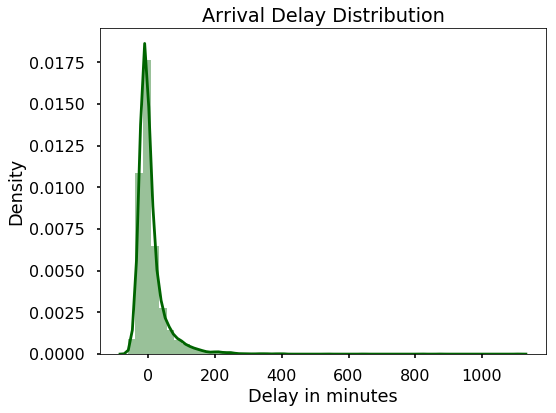

In [7]:
plt.figure(figsize=(8, 6))
sns.distplot(arr, color = 'darkgreen')
plt.title('Arrival Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

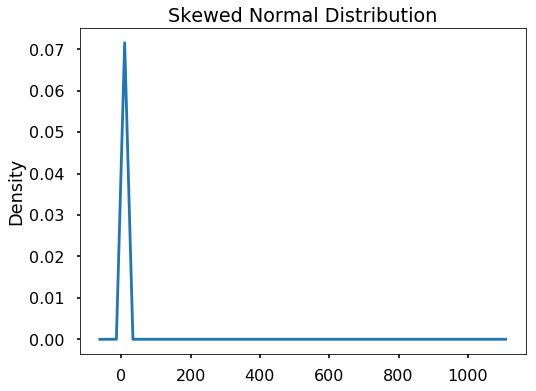

In [8]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(arr), max(arr))
skewed = scipy.stats.skewnorm.pdf(x, loc = np.mean(arr), a = scipy.stats.skew(arr))
plt.plot(x, skewed);
plt.title('Skewed Normal Distribution')
plt.ylabel('Density');

In [9]:
print('Correlation between departure delay and arrival delay: {:.4f}.'.
      format(np.corrcoef(arr, dep)[0][1]))
print('Skew of Arrival Delay: {:.4f}.'.format(scipy.stats.skew(arr)))
print('Average Delay Time: {:.4f} minutes.'.format(np.mean(arr)))

Correlation between departure delay and arrival delay: 0.9221.
Skew of Arrival Delay: 5.2174.
Average Delay Time: 7.4978 minutes.


In [10]:
# Treat all of observations as coming from same distribution
with pm.Model() as pooled_model:
    
    # Alpha is skew of distribution
    alpha = pm.Normal('alpha', mu = 0, sd = 1e5)
    
    # Beta is vector of model parameters: [intercept, slope]
    beta = pm.Normal('beta', mu = 0, sd = 1e5, shape=2)
    
    # Sigma is standard deviation of observations
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Linear equation for the arrival delay based on departure delay
    theta = beta[0] + beta[1] * dep
    
    # The arrival delays are skewed normal
    y = pm.SkewNormal('y', mu=theta, sd=sigma, alpha=alpha, observed=arr)
    
    # Trace from pooled model
    pooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
The acceptance probability does not match the target. It is 0.9325411164961026, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
# Intercept and slope are mean of traces
pooled_intercept, pooled_slope = pooled_trace['beta'].mean(axis=0)
pooled_sigma = pooled_trace['sigma'].mean(axis=0)
pooled_alpha = pooled_trace['alpha'].mean(axis=0)

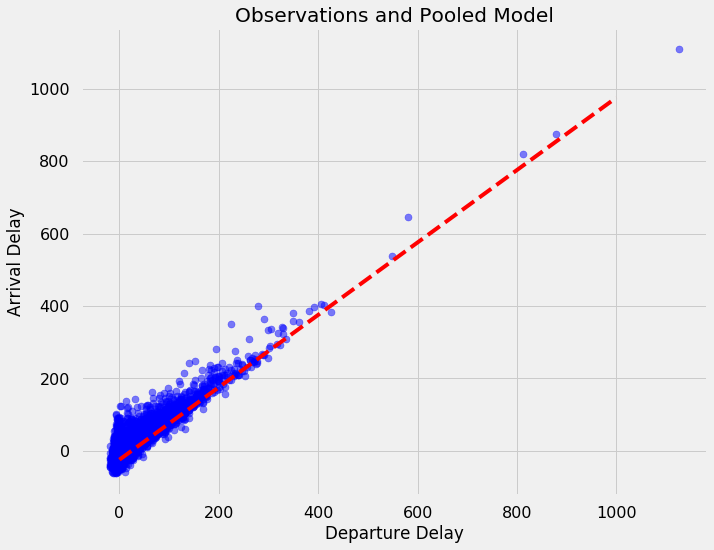

In [12]:
figsize(10, 8)
plt.style.use('fivethirtyeight')
plt.scatter(flights['dep_delay'], (flights['arr_delay']), s = 50, 
           alpha = 0.5, facecolor = 'b', edgecolors = 'b')
xvals = np.linspace(0, 1000)
plt.plot(xvals, pooled_slope * xvals + pooled_intercept, 
         'r--', label = 'Pooled Model Estimate');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');
plt.title('Observations and Pooled Model');

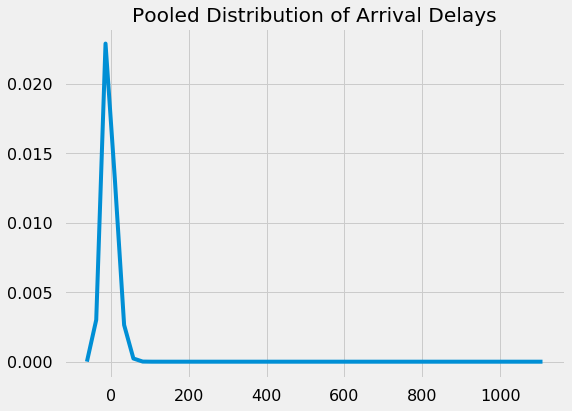

In [13]:
figsize(8, 6)
x = np.linspace(min(arr), max(arr))
pooled_dist = scipy.stats.skewnorm.pdf(x, loc = pooled_intercept, 
                                      scale = pooled_sigma, a = pooled_alpha)
plt.plot(x, pooled_dist)
plt.title('Pooled Distribution of Arrival Delays');

# Completely Unpooled Model

In [14]:
with pm.Model() as unpooled_model:
    # Alpha is skew of distribution
    alpha = pm.Normal('alpha', 0, 1e5)
    
    
    beta0 = pm.Normal('beta0', 0, sd = 1e5, shape = len(carriers))
    beta1 = pm.Normal('beta1', 0, sd = 1e5)
    
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = beta0[carrier_codes] + beta1 * dep
    
    y = pm.SkewNormal('y', theta, sd = sigma, alpha = alpha,
                     observed = arr)
    unpooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta1, beta0, alpha]
The acceptance probability does not match the target. It is 0.91764372993005, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9903021794114205, but should be close to 0.8. Try to increase the number of tuning steps.


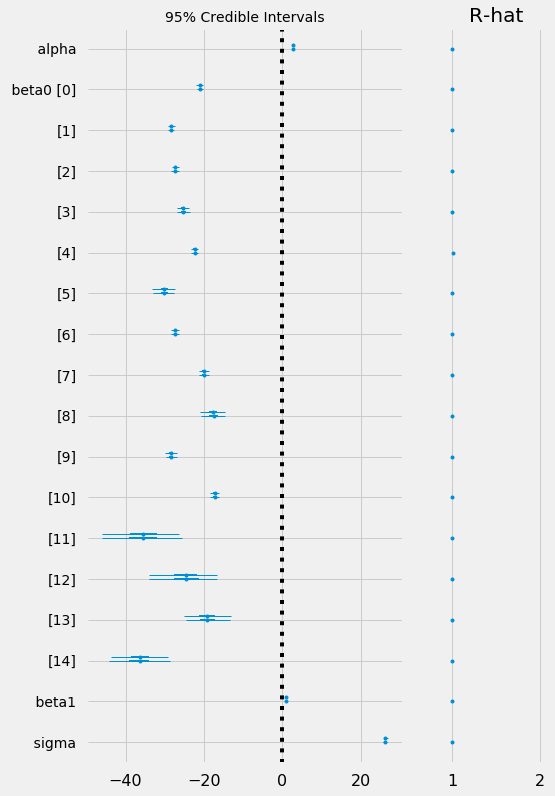

In [15]:
from pymc3 import forestplot

figsize(8, 12)
forestplot(unpooled_trace)

In [16]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = carriers)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = carriers)

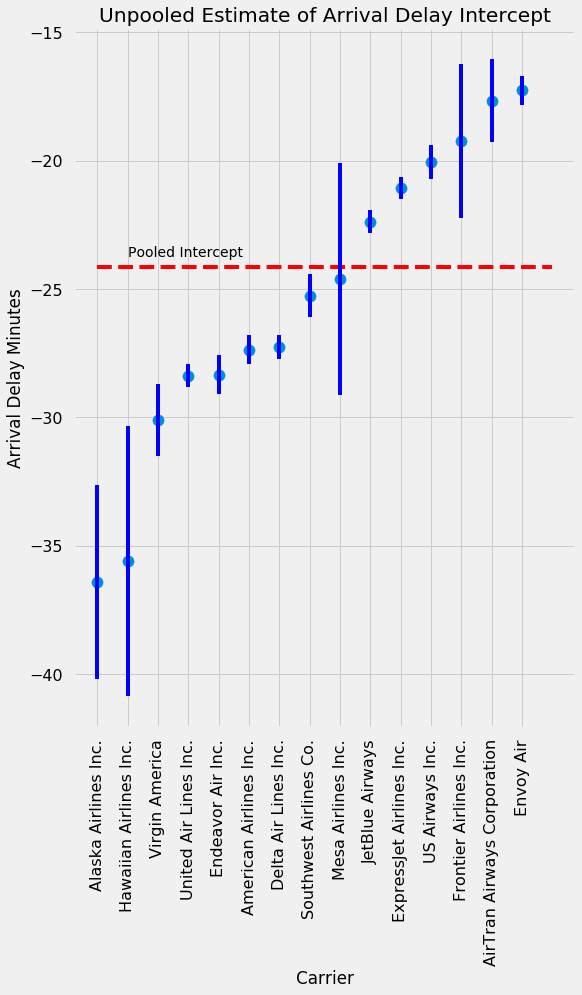

In [17]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i, i], [m - se, m + se], 'b-')
    
plt.xticks(range(len(unpooled_estimates)), order, rotation = 90);
plt.hlines( y = pooled_intercept, color = 'r', linestyles='--', xmin = 0, xmax = len(unpooled_estimates))
plt.text(x = 1, y = pooled_intercept + .4, s = 'Pooled Intercept')
plt.xlabel('Carrier'); plt.ylabel('Arrival Delay Minutes');
plt.title('Unpooled Estimate of Arrival Delay Intercept');

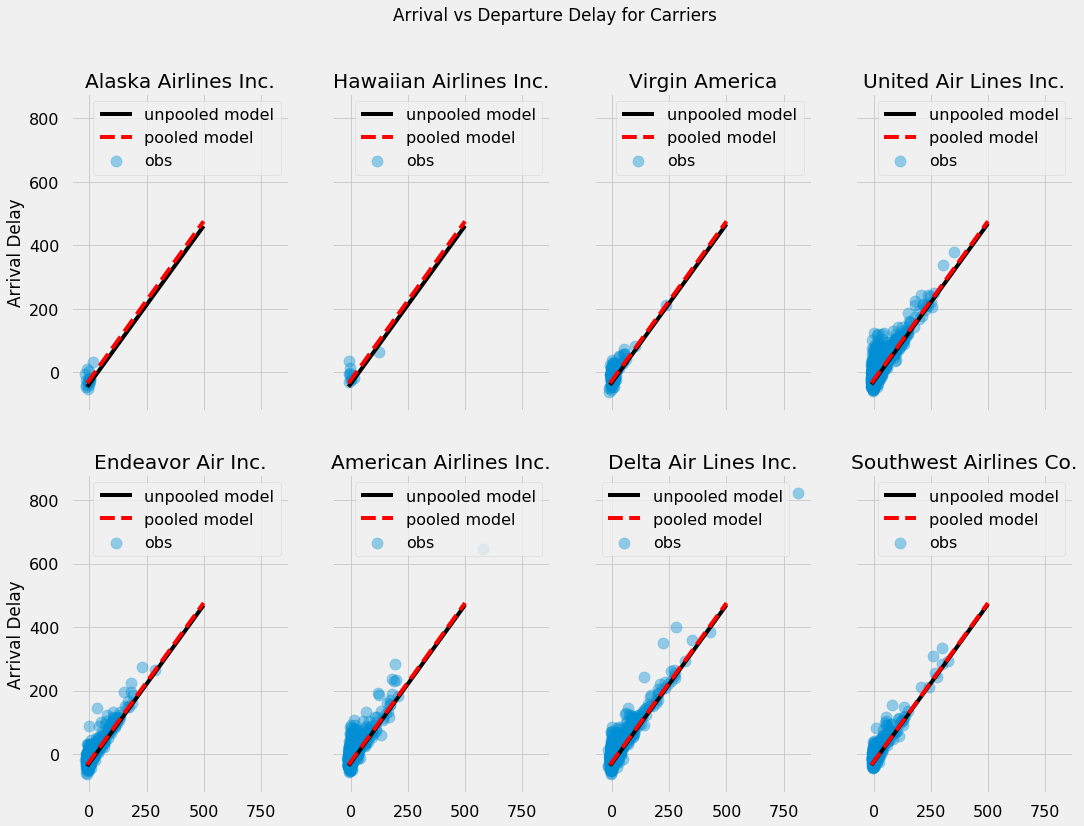

In [18]:
sample_airlines = tuple(order[:8])

fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()

for i,c in enumerate(sample_airlines):
    y = flights['arr_delay'][flights['carrier']==c]
    x = flights['dep_delay'][flights['carrier']==c]
    
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, 
                    alpha=0.4, label = 'obs')
    
    # No pooling model
    b = unpooled_estimates[c]
    # Plot both models and data
    xvals = np.linspace(-10, 500)
    axes[i].plot(xvals, m*xvals+b, label = 'unpooled model', color = 'k')
    axes[i].plot(xvals, pooled_slope*xvals+pooled_intercept, 'r--',
                label = 'pooled model')
    axes[i].set_title(c)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('Arrival Delay')
    
plt.suptitle('Arrival vs Departure Delay for Carriers');

# Partial Pooling

## No predictors

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

In [52]:
with pm.Model() as partial_pooling:
    
    # Skew parameter
    alpha_a = pm.Normal('alpha_a', mu = 0, sd = 1e5)
    
    # Priors
    mu_a = pm.SkewNormal('mu_a', mu=0, sd=1e5, alpha = alpha_a)
    sigma_a = pm.HalfCauchy('sigma_a', beta = 5)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(carriers))

    # Expected Value
    y_hat = a[carrier_codes]
    
    # Model Error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    partial_pooling_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, a, sigma_a_log__, mu_a, alpha_a]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


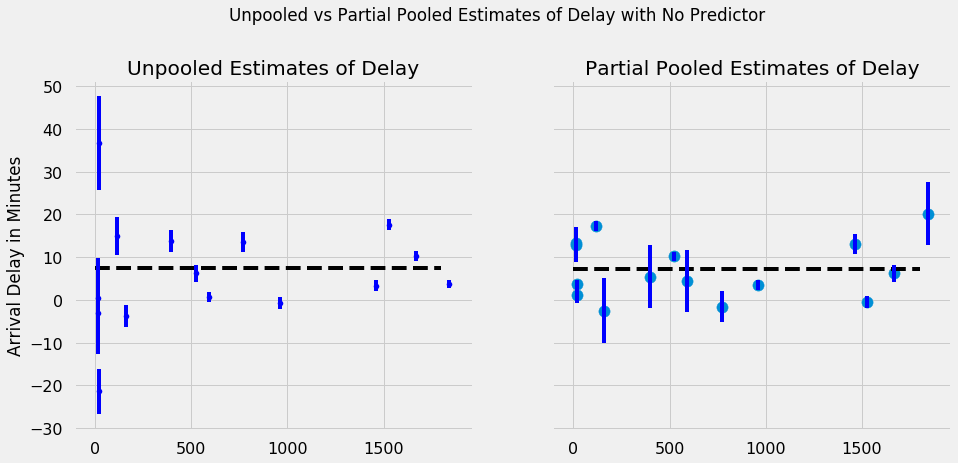

In [53]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

samples, n_carriers = sample_trace.shape
jitter = np.random.normal(scale=10, size=n_carriers)

count_carriers = flights.groupby('carrier')['arr_delay'].count()
unpooled_means = flights.groupby('carrier')['arr_delay'].mean()
unpooled_sd = flights.groupby('carrier')['arr_delay'].std()

unpooled = pd.DataFrame({'n': count_carriers, 'm': unpooled_means, 'sd': unpooled_sd})
unpooled['se'] = unpooled['sd']/np.sqrt(unpooled.n)

axes[0].plot(unpooled['n'] + jitter, unpooled['m'], 'b.')
axes[0].set_ylabel('Arrival Delay in Minutes')
axes[0].set_title('Unpooled Estimates of Delay')

for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat['n'] + j, dat['n'] + j], [dat['m'] - dat['se'], dat['m'] + dat['se']], 'b-')
    
axes[0].hlines(flights['arr_delay'].mean(), 0, 1800, linestyles='--')

means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(count_carriers.values + jitter, means)

for j, n, m, s in zip(jitter, count_carriers.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')
axes[1].set_title('Partial Pooled Estimates of Delay')
axes[1].hlines(sample_trace.mean(), 0, 1800, linestyles='--')
plt.suptitle("Unpooled vs Partial Pooled Estimates of Delay with No Predictor", y = 1.05);

# Varying Intercept model

Allow the intercept to vary across carriers.

In [55]:
with pm.Model() as varying_intercept:
    
    alpha_a = pm.Normal('alpha_a', mu=0, sd=1e5)
    
    mu_a = pm.SkewNormal('mu_a', mu=0, sd=1e5, alpha = alpha_a)
    sigma_a = pm.HalfCauchy('sigma_a', beta= 5)
    
    # Random intercepts for each carrier
    a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape=len(carriers))
    
    # Common Slope
    b = pm.Normal('b', mu=0, sd=1e5)
    
    alpha_y = pm.Normal('alpha_y', mu = 0, sd = 1e5)
    sd_y = pm.HalfCauchy('sd_y', beta= 5)
    
    y_hat = a[carrier_codes] + b * dep
    
    y_like = pm.SkewNormal('y_like', mu=y_hat, sd=sd_y, alpha = alpha_y, observed=arr)
    
    varying_intercept_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y_log__, alpha_y, b, a, sigma_a_log__, mu_a, alpha_a]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000022296F10F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000022296F10F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\W...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method PollIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 26, 2, 16, 18, 358033, tzinfo=tzutc()), 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'session': 'cb4d29287a04e3eba3ba918fc2cef31b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'cb4d29287a04e3eba3ba918fc2cef31b']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 26, 2, 16, 18, 358033, tzinfo=tzutc()), 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'session': 'cb4d29287a04e3eba3ba918fc2cef31b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'cb4d29287a04e3eba3ba918fc2cef31b'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 26, 2, 16, 18, 358033, tzinfo=tzutc()), 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'session': 'cb4d29287a04e3eba3ba918fc2cef31b', 'username': '', 'version': '5.2'}, 'metadata': {}, 'msg_id': '10183570a067f1c091be8dceec1755b9', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with pm.Model() as varying_intercept:\n    \n    a...   \n    varying_intercept_trace = pm.sample(1000)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-55-ad608c44ce6b>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 222b2bc9198, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x00000222B22E4780, file "<ipython-input-55-ad608c44ce6b>", line 1>
        result = <ExecutionResult object at 222b2bc9198, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x00000222B22E4780, file "<ipython-input-55-ad608c44ce6b>", line 1>, result=<ExecutionResult object at 222b2bc9198, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x00000222B22E4780, file "<ipython-input-55-ad608c44ce6b>", line 1>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'In': ['', "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "flights = pd.read_csv('data/flights.csv', index_...'Arrival Delay');\nplt.ylabel('Density Estimate');", "sns.lmplot('dep_delay', 'arr_delay', flights, \n ...;\nplt.title('Arrival Delay vs. Departure Delay');", 'flights = flights.sample(frac=1, random_state=50)[:10000]', "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", "dep = np.array(flights['dep_delay'].values)\narr = np.array(flights['arr_delay'].values)", "plt.figure(figsize=(8, 6))\nsns.distplot(arr, col...label('Delay in minutes'); plt.ylabel('Density');", "plt.figure(figsize=(8, 6))\nx = np.linspace(min(a...ewed Normal Distribution')\nplt.ylabel('Density');", "print('Correlation between departure delay and a...elay Time: {:.4f} minutes.'.format(np.mean(arr)))", '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', "# Intercept and slope are mean of traces\npooled_...pooled_alpha = pooled_trace['alpha'].mean(axis=0)", "figsize(10, 8)\nplt.style.use('fivethirtyeight')\n...ay');\nplt.title('Observations and Pooled Model');", "figsize(8, 6)\nx = np.linspace(min(arr), max(arr)...t.title('Pooled Distribution of Arrival Delays');", 'with pm.Model() as unpooled_model:\n    # Alpha i...erved = arr)\n    unpooled_trace = pm.sample(1000)', 'from pymc3 import forestplot\n\nfigsize(8, 12)\nforestplot(unpooled_trace)', "unpooled_estimates = pd.Series(unpooled_trace['b...led_trace['beta0'].std(axis=0), index = carriers)", "order = unpooled_estimates.sort_values().index\n\n...('Unpooled Estimate of Arrival Delay Intercept');", "sample_airlines = tuple(order[:8])\n\nfig, axes = ...title('Arrival vs Departure Delay for Carriers');", 'with pm.Model() as partial_pooling:\n    \n    # S...\n    \n    partial_pooling_trace = pm.sample(1000)', ...], 'Out': {15: <matplotlib.gridspec.GridSpec object>, 21:         year  month  day  dep_time  sched_dep_ti...2  
73491              2  
231484             3  , 23: Text(0.5,0.98,'Unpooled vs Partial Pooled Estimates of Delay with No Predictor'), 27: -35.83353238508213, 28: array([-28.,  27., -19., ...,  -3., -44.,  57.]), 29: 7.4978, 34: (array([9.047e+03, 8.240e+02, 1.020e+02, 2.200e+0...     1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([ -62. ,   55.1,  172.2,  289.3,  406.4,  ...,  640.6,  757.7,
        874.8,  991.9, 1109. ]), <a list of 10 Patch objects>), 35: (array([9.047e+03, 8.240e+02, 1.020e+02, 2.200e+0...     1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([ -62. ,   55.1,  172.2,  289.3,  406.4,  ...,  640.6,  757.7,
        874.8,  991.9, 1109. ]), <a list of 10 Patch objects>), 36: array([0, 1, 2, ..., 6, 1, 7], dtype=int64), 37: Counter({1: 1827, 4: 1658, 0: 1525, 2: 1463, 6: ..., 5: 147, 8: 96, 13: 26, 14: 17, 12: 12, 11: 10}), ...}, '_': 77145.52728711304, '_15': <matplotlib.gridspec.GridSpec object>, '_21':         year  month  day  dep_time  sched_dep_ti...2  
73491              2  
231484             3  , '_23': Text(0.5,0.98,'Unpooled vs Partial Pooled Estimates of Delay with No Predictor'), '_27': -35.83353238508213, '_28': array([-28.,  27., -19., ...,  -3., -44.,  57.]), '_29': 7.4978, ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'In': ['', "import numpy as np\nimport pandas as pd\n\nimport m...lib', 'inline')\n\nimport pymc3 as pm\n\nimport scipy", "flights = pd.read_csv('data/flights.csv', index_...'Arrival Delay');\nplt.ylabel('Density Estimate');", "sns.lmplot('dep_delay', 'arr_delay', flights, \n ...;\nplt.title('Arrival Delay vs. Departure Delay');", 'flights = flights.sample(frac=1, random_state=50)[:10000]', "carriers = flights['carrier'].unique()\ncarrier_l...flights['carrier'].replace(carrier_lookup).values", "dep = np.array(flights['dep_delay'].values)\narr = np.array(flights['arr_delay'].values)", "plt.figure(figsize=(8, 6))\nsns.distplot(arr, col...label('Delay in minutes'); plt.ylabel('Density');", "plt.figure(figsize=(8, 6))\nx = np.linspace(min(a...ewed Normal Distribution')\nplt.ylabel('Density');", "print('Correlation between departure delay and a...elay Time: {:.4f} minutes.'.format(np.mean(arr)))", '# Treat all of observations as coming from same ...m pooled model\n    pooled_trace = pm.sample(1000)', "# Intercept and slope are mean of traces\npooled_...pooled_alpha = pooled_trace['alpha'].mean(axis=0)", "figsize(10, 8)\nplt.style.use('fivethirtyeight')\n...ay');\nplt.title('Observations and Pooled Model');", "figsize(8, 6)\nx = np.linspace(min(arr), max(arr)...t.title('Pooled Distribution of Arrival Delays');", 'with pm.Model() as unpooled_model:\n    # Alpha i...erved = arr)\n    unpooled_trace = pm.sample(1000)', 'from pymc3 import forestplot\n\nfigsize(8, 12)\nforestplot(unpooled_trace)', "unpooled_estimates = pd.Series(unpooled_trace['b...led_trace['beta0'].std(axis=0), index = carriers)", "order = unpooled_estimates.sort_values().index\n\n...('Unpooled Estimate of Arrival Delay Intercept');", "sample_airlines = tuple(order[:8])\n\nfig, axes = ...title('Arrival vs Departure Delay for Carriers');", 'with pm.Model() as partial_pooling:\n    \n    # S...\n    \n    partial_pooling_trace = pm.sample(1000)', ...], 'Out': {15: <matplotlib.gridspec.GridSpec object>, 21:         year  month  day  dep_time  sched_dep_ti...2  
73491              2  
231484             3  , 23: Text(0.5,0.98,'Unpooled vs Partial Pooled Estimates of Delay with No Predictor'), 27: -35.83353238508213, 28: array([-28.,  27., -19., ...,  -3., -44.,  57.]), 29: 7.4978, 34: (array([9.047e+03, 8.240e+02, 1.020e+02, 2.200e+0...     1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([ -62. ,   55.1,  172.2,  289.3,  406.4,  ...,  640.6,  757.7,
        874.8,  991.9, 1109. ]), <a list of 10 Patch objects>), 35: (array([9.047e+03, 8.240e+02, 1.020e+02, 2.200e+0...     1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]), array([ -62. ,   55.1,  172.2,  289.3,  406.4,  ...,  640.6,  757.7,
        874.8,  991.9, 1109. ]), <a list of 10 Patch objects>), 36: array([0, 1, 2, ..., 6, 1, 7], dtype=int64), 37: Counter({1: 1827, 4: 1658, 0: 1525, 2: 1463, 6: ..., 5: 147, 8: 96, 13: 26, 14: 17, 12: 12, 11: 10}), ...}, '_': 77145.52728711304, '_15': <matplotlib.gridspec.GridSpec object>, '_21':         year  month  day  dep_time  sched_dep_ti...2  
73491              2  
231484             3  , '_23': Text(0.5,0.98,'Unpooled vs Partial Pooled Estimates of Delay with No Predictor'), '_27': -35.83353238508213, '_28': array([-28.,  27., -19., ...,  -3., -44.,  57.]), '_29': 7.4978, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\Will Koehrsen\Documents\eecs-491\assign\A2\<ipython-input-55-ad608c44ce6b> in <module>()
     16     
     17     y_hat = a[carrier_codes] + b * dep
     18     
     19     y_like = pm.SkewNormal('y_like', mu=y_hat, sd=sd_y, alpha = alpha_y, observed=arr)
     20     
---> 21     varying_intercept_trace = pm.sample(1000)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}, {'a': array([-0.64157592,  0.88038835, -0.79475205, -0...40991905,  0.94272238, -0.24909886,  0.33563539]), 'alpha_a': array(0.77690447), 'alpha_y': array(0.02792566), 'b': array(-0.06164734), 'mu_a': array(-0.58926221), 'sd_y_log__': array(2.00410449), 'sigma_a_log__': array(2.00345189)}], trace=None, chain_idx=0, chains=2, njobs=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[443364284, 1066378115], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, **kwargs={})
    414     parallel = njobs > 1 and chains > 1 and not has_population_samplers
    415     if parallel:
    416         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, njobs))
    417         _print_step_hierarchy(step)
    418         try:
--> 419             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': [443364284, 1066378115], 'start': [{'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}, {'a': array([-0.64157592,  0.88038835, -0.79475205, -0...40991905,  0.94272238, -0.24909886,  0.33563539]), 'alpha_a': array(0.77690447), 'alpha_y': array(0.02792566), 'b': array(-0.06164734), 'mu_a': array(-0.58926221), 'sd_y_log__': array(2.00410449), 'sigma_a_log__': array(2.00345189)}], ...}
    420         except pickle.PickleError:
    421             _log.warn("Could not pickle model, sampling singlethreaded.")
    422             _log.debug('Pickling error:', exec_info=True)
    423             parallel = False

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _mp_sample(**kwargs={'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    944 
    945     chain_nums = list(range(chain, chain + chains))
    946     pbars = [kwargs.pop('progressbar')] + [False] * (chains - 1)
    947     jobs = (delayed(_sample)(*args, **kwargs)
    948             for args in zip(chain_nums, pbars, rseed, start))
--> 949     traces = Parallel(n_jobs=njobs)(jobs)
        traces = undefined
        njobs = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    950     return MultiTrace(traces)
    951 
    952 
    953 def stop_tuning(step):

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Feb 25 21:16:48 2018
PID: 23100        Python 3.6.4: C:\Users\Will Koehrsen\Anaconda3\python.exe
...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 443364284, {'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}), {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 443364284, {'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)})
        kwargs = {'draws': 1500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _sample(chain=0, progressbar=True, random_seed=443364284, start={'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}, draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    521                             tune, model, random_seed)
    522     if progressbar:
    523         sampling = tqdm(sampling, total=draws)
    524     try:
    525         strace = None
--> 526         for it, strace in enumerate(sampling):
        it = 102
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =   6%|6         | 97/1500 [00:03<00:48, 28.72it/s]
    527             if live_plot:
    528                 if live_plot_kwargs is None:
    529                     live_plot_kwargs = {}
    530                 if it >= skip_first:

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\tqdm\_tqdm.py in __iter__(self=  6%|6         | 97/1500 [00:03<00:48, 28.72it/s])
    944             except AttributeError:
    945                 raise TqdmDeprecationWarning("""\
    946 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    947 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    948 
--> 949             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    950                 yield obj
    951                 # Update and possibly print the progressbar.
    952                 # Note: does not call self.update(1) for speed optimisation.
    953                 n += 1

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\sampling.py in _iter_sample(draws=1500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=443364284)
    619         step.tune = bool(tune)
    620         for i in range(draws):
    621             if i == tune:
    622                 step = stop_tuning(step)
    623             if step.generates_stats:
--> 624                 point, states = step.step(point)
        point = {'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)}
        states = [{'depth': 1, 'diverging': True, 'energy': 1443696.7683069583, 'energy_error': 0.0, 'max_energy_error': inf, 'mean_tree_accept': 0.0, 'step_size': 6.116793835454088e-65, 'step_size_bar': 3.1769002429886417e-54, 'tree_size': 1, 'tune': True}]
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    625                 if strace.supports_sampler_stats:
    626                     strace.record(point, states)
    627                 else:
    628                     strace.record(point)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\step_methods\arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'a': array([ 0.29433362,  0.17869008,  0.45769898,  0...12972396,  0.47771167,  0.03048584, -0.67387912]), 'alpha_a': array(-0.90692508), 'alpha_y': array(-0.58401869), 'b': array(0.32207605), 'mu_a': array(0.83920823), 'sd_y_log__': array(0.85310086), 'sigma_a_log__': array(2.39262782)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([ 0.85310086, -0.58401869,  0.32207605,  0...2,  2.39262782,  0.83920823,
       -0.90692508])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 0.85310086, -0.58401869,  0.32207605,  0...2,  2.39262782,  0.83920823,
       -0.90692508]))
    110         """Perform a single HMC iteration."""
    111         p0 = self.potential.random()
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
--> 115             self.potential.raise_ok()
        self.potential.raise_ok = <bound method QuadPotentialDiagAdapt.raise_ok of...hmc.quadpotential.QuadPotentialDiagAdapt object>>
    116             raise ValueError('Bad initial energy: %s. The model '
    117                              'might be misspecified.' % start.energy)
    118 
    119         adapt_step = self.tune and self.adapt_step_size

...........................................................................
C:\Users\Will Koehrsen\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\quadpotential.py in raise_ok(self=<pymc3.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt object>)
    185 
    186         self._n_samples += 1
    187 
    188     def raise_ok(self):
    189         if np.any(self._stds == 0):
--> 190             raise ValueError('Mass matrix contains zeros on the diagonal. '
    191                              'Some derivatives might always be zero.')
    192         if np.any(self._stds < 0):
    193             raise ValueError('Mass matrix contains negative values on the '
    194                              'diagonal.')

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.
___________________________________________________________________________

In [ ]:
plt.figure(8, 18)
forestplot(varying_intercept_trace)